In [1]:
import torch
import torch.nn as nn 
from torch.functional import F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
import datashader as ds
import datashader.transfer_functions as tf
import seaborn as sns

from functools import partial
from tqdm.notebook import tqdm
from sconf import Config

import sys
sys.path.append('..')

from classes import MLP, MultiTaskLoss
from utils import non_markovian_midprice

/Users/nicholasmartin/Programming/Research/optimal-execution-kernel-decomposition/venv/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
config = Config('config.yaml')

In [3]:
rng = np.random.default_rng(123)

num_paths = config.num_paths
num_timesteps = config.num_timesteps
final_time = config.final_time
initial_price = config.initial_price
decomp_dim = config.decomp_dim
num_episodes = config.num_episodes
batch_size = config.batch_size

dt = final_time/num_timesteps

inital_prices = np.ones((1, num_paths)) * initial_price

permenant_price_impact_func = lambda x: 0.01*x
# kernel_function = lambda x,y: (np.abs((x-y)+1e-3)**(0.51-1))
# kernel_function = lambda x,y: (1/(np.sqrt(2*np.pi)))*np.exp(-(x-y)**2)
kernel_function = lambda x,y: np.exp(-np.abs((x-y)))
K0 = kernel_function(0,0)

nu_vals = rng.uniform(-50, 100,size=(num_timesteps, num_paths))

sigma_true = 0.1

In [4]:
network = MLP(decomp_dim=decomp_dim)
# mtloss = MultiTaskLoss(num_losses=3)
optimizer = torch.optim.Adam(params=[*network.parameters(), 
                                #      *mtloss.parameters()
                                     ],
                             lr=3e-4)

# Generate Data

In [5]:
sim_prices, noise_process = non_markovian_midprice(inital_prices=inital_prices,
                             permenant_price_impact_func=permenant_price_impact_func,
                             nu_vals=nu_vals,
                             kernel_function=kernel_function,
                             dt=dt,
                             rng=rng,
                             num_paths=num_paths,
                             num_timesteps=num_timesteps,
                             sigma=sigma_true)

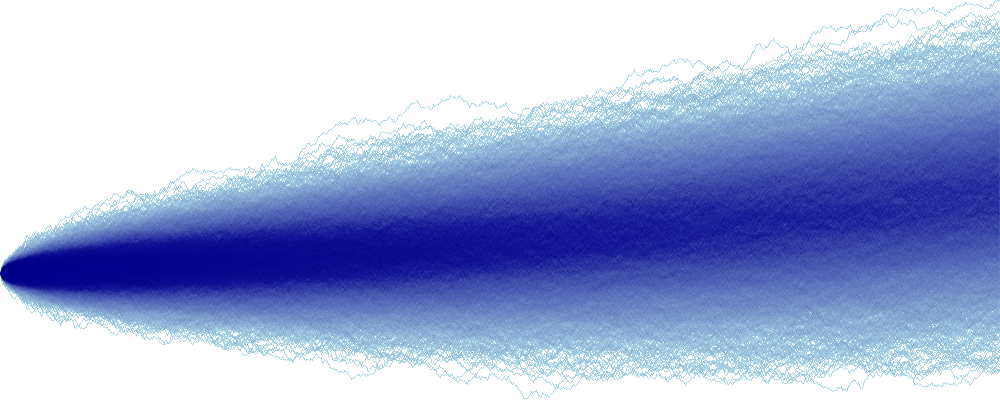

In [6]:
n = num_paths
points = num_timesteps
time = np.linspace(0, 1, num_timesteps)

walks = pd.DataFrame(sim_prices.T)

cvs = ds.Canvas(plot_height=400, plot_width=1000)
agg = cvs.line(walks, x=time, y=list(range(points)), agg=ds.count(), axis=1, line_width=0)
img = tf.shade(agg, how='eq_hist')

img

# NN Approach

In [7]:
loss_vals = {}
sigma_tracker = {}
for episode in tqdm(range(num_episodes), position=0, leave=True):
    loss_vals[episode] = []
    sigma_tracker[episode] = []

    for batch_index in tqdm(range(1, int(num_paths/batch_size)+1), position=1, leave=True):

        lower_bound = int((batch_index-1)*batch_size)
        upper_bound = int((batch_index)*batch_size)

        B_n_t = torch.zeros((decomp_dim, batch_size))
        S_t = torch.ones((1, batch_size)) * initial_price

        true_vals = sim_prices[:, lower_bound:upper_bound]
        batch_nu_vals = nu_vals[:, lower_bound:upper_bound]

        for timestep in range(1, num_timesteps):
            
            price_impacts = network.kappa * torch.FloatTensor(batch_nu_vals[timestep])
            time_tensor = torch.FloatTensor([timestep*dt])
            f_vals = network(time_tensor)

            zero_time = torch.FloatTensor([dt*timestep])
            zero_f = network(zero_time)
            K_t_t = zero_f.dot(zero_f)

            time_tensor = torch.FloatTensor([timestep*dt])
            time_tensor.requires_grad = True

            f_prime_vals = torch.autograd.functional.jacobian(network, 
                                            time_tensor, 
                                            create_graph=True)

            f_prime_vals = f_prime_vals.flatten()

            kernel_time_t = K_t_t
            kernel_price_impact = kernel_time_t * price_impacts * dt

            w_t = (dt**0.5)*torch.randn((batch_size))
            sigma_w_t = network.sigma * w_t
            sigma_tracker[episode].append(network.sigma.detach().item())

            dB_n_t = torch.tile(f_vals, dims=(batch_size, 1)).T * price_impacts * dt
            B_n_t = B_n_t.detach() + dB_n_t
            sum_of_sub_procces = torch.matmul(f_prime_vals, B_n_t) * dt

            dS_t = kernel_price_impact + sigma_w_t + sum_of_sub_procces
            S_t = S_t.detach() + dS_t

            # Calculate Differences in 1st to 2nd moment
            pred_mean = torch.mean(S_t)
            true_means = torch.FloatTensor([np.mean(true_vals)])
            diff_means = torch.abs(pred_mean-true_means)

            pred_std = torch.std(S_t)
            true_stds = torch.FloatTensor([np.std(true_vals)])
            diff_stds = torch.abs(pred_std-true_stds)

            kernel_loss = torch.pow(torch.FloatTensor([K0]) - K_t_t, 2)

            # loss_tensor = torch.concat([diff_means, diff_stds, kernel_loss])
            loss = diff_means # + 0.01*kernel_loss
            # loss = mtloss(loss_tensor)

            loss_vals[episode].append({'timestep': timestep,
                                       'mt_loss': loss.detach().item(),
                                       'mean_loss': diff_means.detach().item(),
                                       'std_loss': diff_stds.detach().item(),
                                       'kernel_loss': kernel_loss.detach().item()})

            network.zero_grad()
            optimizer.zero_grad()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(network.parameters(), 1)
            optimizer.step()

            network.zero_grad()
            optimizer.zero_grad()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

KeyboardInterrupt: 

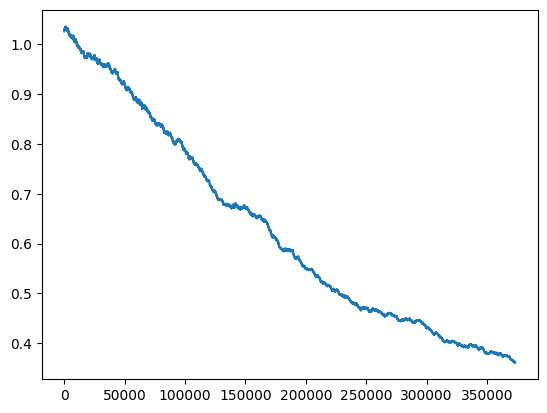

In [8]:
plt.plot(np.hstack([np.array(_) for _ in sigma_tracker.values()]))
plt.show()

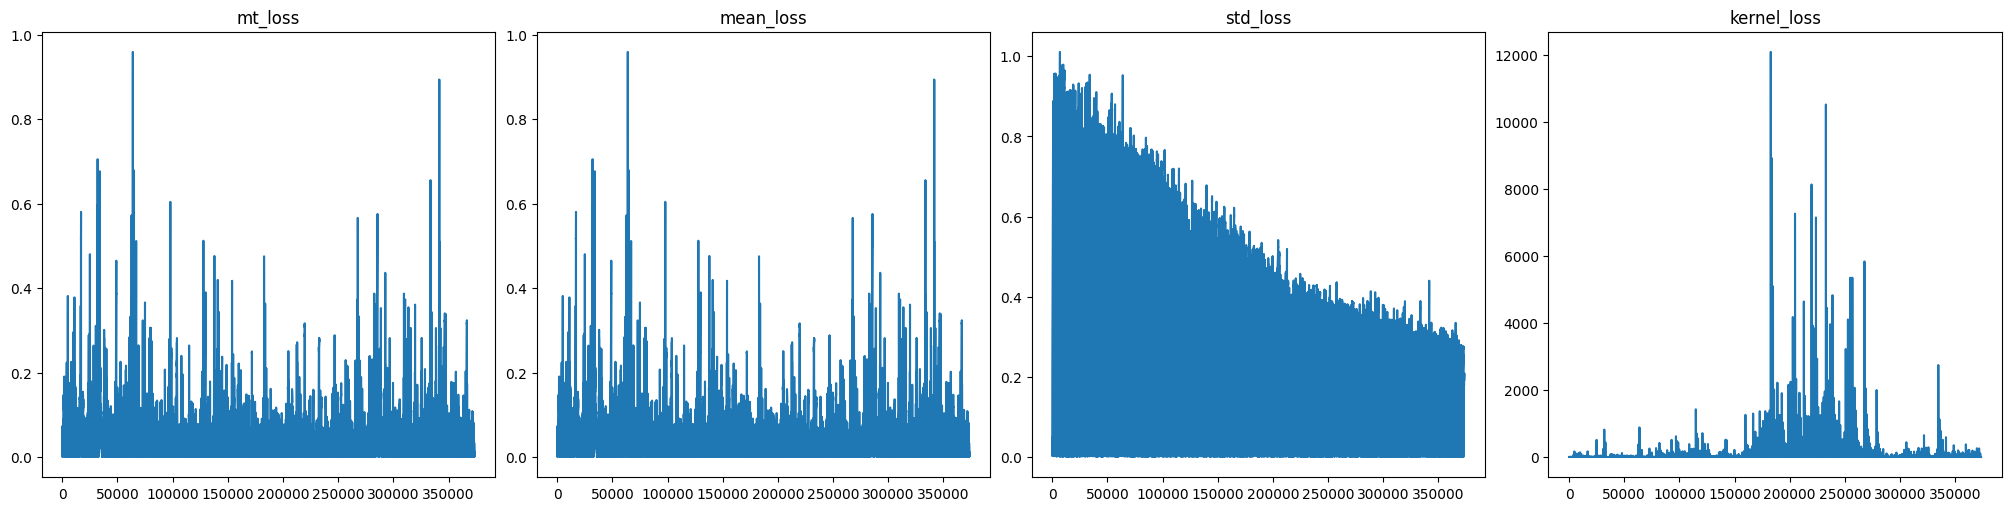

In [9]:
loss_types = ('mt_loss', 'mean_loss', 'std_loss', 'kernel_loss')

fig, ax = plt.subplots(1, len(loss_types), figsize=(5*len(loss_types), 5), constrained_layout=True)

for plot_index, loss_type in enumerate(loss_types):
    ax[plot_index].plot(pd.concat([pd.DataFrame(loss_vals[_])[loss_type][:] for _ in loss_vals.keys()]).values)
    ax[plot_index].set_title(loss_type)

plt.show()

In [10]:
network.eval()

batch_size = 10_000

batch_nu_vals = rng.uniform(-50, 100,size=(num_timesteps, batch_size))

B_n_t = torch.zeros((decomp_dim, batch_size))
S_t = torch.ones((1, batch_size)) * initial_price

B_n_list = [B_n_t.detach().numpy()]
S_t_list = [S_t.detach().numpy()]

for timestep in range(1, num_timesteps):

    price_impacts = torch.FloatTensor(permenant_price_impact_func(batch_nu_vals[timestep]))
    net_vals = network(torch.FloatTensor([timestep*dt]))

    f_vals = net_vals
    
    time_tensor = torch.FloatTensor([timestep*dt])
    time_tensor.requires_grad = True

    f_prime_vals = torch.autograd.functional.jacobian(network, 
                                    time_tensor, 
                                    create_graph=False)
    
    f_prime_vals = f_prime_vals.flatten()

    kernel_time_t = f_vals.dot(f_vals)
    kernel_price_impact = kernel_time_t * price_impacts * dt

    w_t = (dt**0.5)*torch.randn((batch_size))
    sigma_w_t = network.sigma * w_t

    dB_n_t = torch.tile(f_vals, dims=(batch_size, 1)).T * price_impacts * dt
    B_n_t = B_n_t.detach() + dB_n_t
    B_n_list.append(B_n_t.detach().numpy())

    sum_of_sub_procces = torch.matmul(f_prime_vals, B_n_t) * dt

    dS_t = kernel_price_impact + sigma_w_t + sum_of_sub_procces
    S_t = S_t.detach() + dS_t

    S_t_list.append(S_t.detach().numpy())

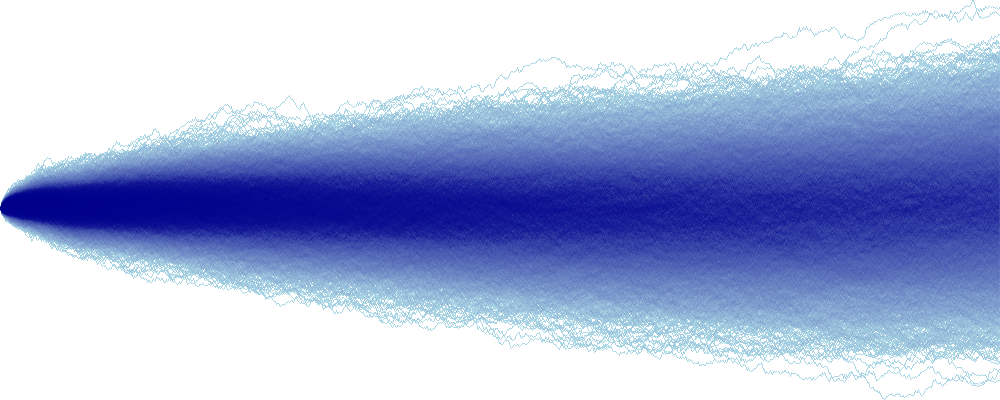

In [11]:
nn_sim_prices = np.vstack(S_t_list)

n = num_paths
points = num_timesteps
time = np.linspace(0, 1, num_timesteps)

walks = pd.DataFrame(nn_sim_prices.T)

cvs = ds.Canvas(plot_height=400, plot_width=1000)
agg = cvs.line(walks, x=time, y=list(range(points)), agg=ds.count(), axis=1, line_width=0)
img = tf.shade(agg, how='eq_hist')

img

# Distribution Plots

In [12]:
val_nu_vals = rng.uniform(-50, 100,size=(num_timesteps, 10_000))
val_inital_prices = np.ones((1, 10_000)) * initial_price
val_sim_prices, _ = non_markovian_midprice(inital_prices=val_inital_prices,
                             permenant_price_impact_func=permenant_price_impact_func,
                             nu_vals=val_nu_vals,
                             kernel_function=kernel_function,
                             dt=dt,
                             rng=rng,
                             num_paths=10_000,
                             num_timesteps=num_timesteps,
                             sigma=sigma_true)

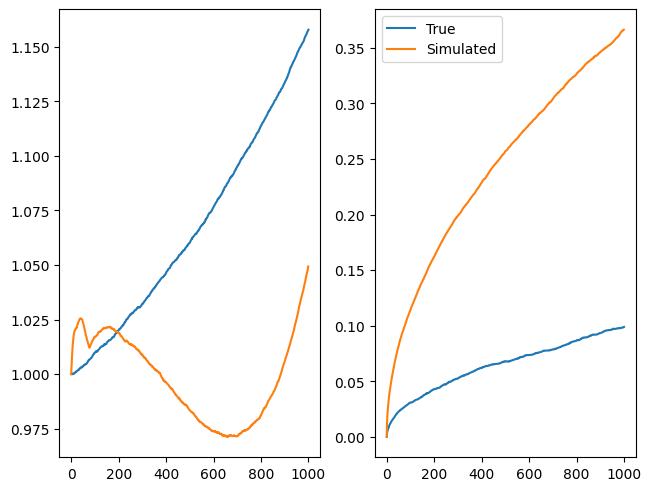

In [13]:
fig, ax = plt.subplots(1,2, constrained_layout=True)

nn_sim_prices = np.vstack(S_t_list)

ax[0].plot(val_sim_prices[:, :1000].mean(axis=1))
ax[0].plot(nn_sim_prices.mean(axis=1))

ax[1].plot(val_sim_prices[:, :1000].std(axis=1), label='True')
ax[1].plot(nn_sim_prices.std(axis=1), label='Simulated')

plt.legend()
plt.show()

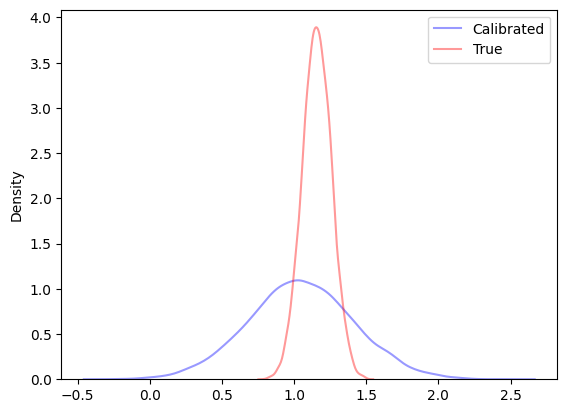

In [14]:
final_sim_prices = np.vstack(S_t_list)[-1]
final_val_true_prices = val_sim_prices[-1]

sns.kdeplot(final_sim_prices, alpha=0.4, color='blue', label='Calibrated')
sns.kdeplot(final_val_true_prices, alpha=0.4, color='red', label='True')
plt.legend()
plt.show()

# Kernel Plots

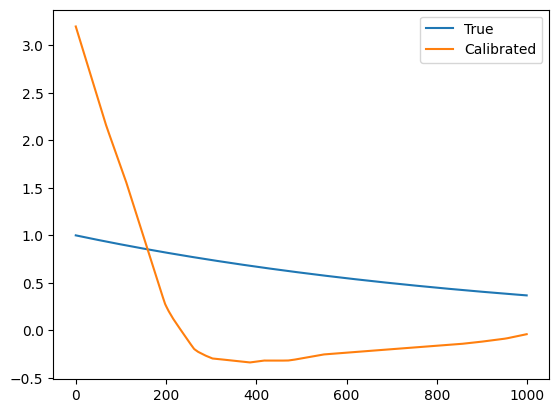

In [ ]:
kernel_plot = []
kernel_plot_two = []

base_val = network(torch.FloatTensor([0])).detach()
for i in range(0, num_timesteps):
    val = network(torch.FloatTensor([i*dt]))
    kernel_plot.append(val.dot(base_val).detach().item())

partial_func = partial(kernel_function, y=0)
for i in range(0, num_timesteps):
    val = partial_func(i*dt)
    kernel_plot_two.append(val)

plt.plot(kernel_plot_two, label='True')
plt.plot(kernel_plot, label='Calibrated')
plt.legend()
plt.show()

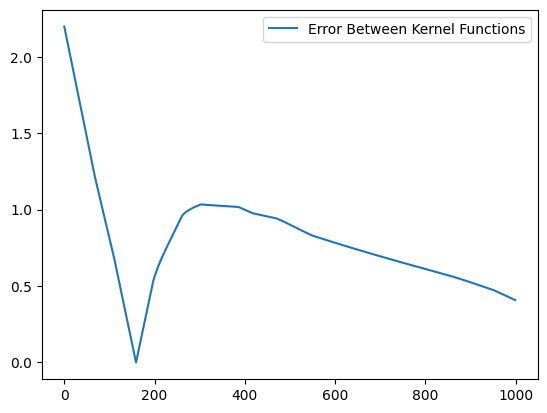

In [ ]:
kernel_plot = []
kernel_plot_two = []

base_val = network(torch.FloatTensor([0])).detach()
for i in range(0, num_timesteps):
    val = network(torch.FloatTensor([i*dt]))[:decomp_dim]
    kernel_plot.append(val.dot(base_val).detach().item())

partial_func = partial(kernel_function, y=0)
for i in range(0, num_timesteps):
    val = partial_func(i*dt)
    kernel_plot_two.append(val)

plt.plot(np.abs(np.array(kernel_plot_two)-np.array(kernel_plot)),
         label='Error Between Kernel Functions')
plt.legend()
plt.show()